# 图像前景背景分割

----

## 任务目的

本次实验将在图像中标记前景和背景区域并使用朴素贝叶斯分类器对图像分类，正确分离图像的前景和背景。

## 任务内容

<a href='#创建贝叶斯分类器'>创建贝叶斯分类器</a><br/>
<a href='#定义build_bayes_graph和show_labeling函数'>定义build_bayes_graph和show_labeling函数</a><br/>
<a href='#定义cut_gragh函数'>定义cut_gragh函数</a><br/>
<a href='#主函数'>主函数</a><br/>

## 任务原理

<div>
    <img src="../../image/ComputerVision/8-1.png" style="float:left" width="600">
</div>

## 任务步骤

### 创建贝叶斯分类器
```python

import numpy as np
def gauss(m,v,x):
    """ 用独立均值 m 和方差 v 评估 d 维高斯分布 """
    if len(x.shape)==1:
        n,d = 1,x.shape[0]  
    else:
        n,d = x.shape
  # 协方差矩阵，减去均值  
    S = np.diag(1/v)
    x = x-m  # 概率的乘积  
    y = np.exp(-0.5*np.diag(np.dot(x,np.dot(S,x.T))))
    # 归一化并返回
    return y * (2*np.pi)**(-d/2.0) / ( np.sqrt(np.prod(v)) + 1e-6)

class BayesClassifier(object):
    def __init__(self):
        self.labels = []
        self.mean = []
        self.var = []
        self.n = 0
    def train(self,data,labels = None):
        if labels == None:
            labels = range(len(data))
        self.labels = labels
        self.n = len(labels)

        for c in data:
            self.mean.append(np.mean(c,axis=0))
            self.var.append(np.var(c,axis=0))
    def classify(self,point):
        est_prob = np.array([gauss(m,v,point) for m,v in zip(self.mean,self.var)])

        ndx = est_prob.argmax(axis = 0)
        est_labels = np.array([self.labels[n] for n in ndx])
        return est_labels,est_prob


```

### 定义build_bayes_graph和show_labeling函数
```python
from pygraph.classes.digraph import digraph 
from pygraph.algorithms.minmax import maximum_flow
import pdb
import matplotlib.pyplot as plt
def build_bayes_graph(im,labels,sigma=1e2,kappa=2):  
    """ 从像素四邻域建立一个图，前景和背景（前景用 1 标记，背景用 -1 标记，    
    其他的用 0 标记）由 labels 决定，并用朴素贝叶斯分类器建模 """
    m,n = im.shape[:2]
    # 每行是一个像素的 RGB 向量  
    vim = im.reshape((-1,3))
      # 前景和背景（RGB）  
    foreground = im[labels==1].reshape((-1,3))  
    background = im[labels==-1].reshape((-1,3))  
    train_data = [foreground,background]    
    # 训练朴素贝叶斯分类器  
    bc = BayesClassifier()  
    bc.train(train_data)
      # 获取所有像素的概率  
    bc_lables,prob = bc.classify(vim)  
    prob_fg = prob[0]  
    prob_bg = prob[1]
    #prob.reshape()
      # 用m * n +2 个节点创建图  
    gr = digraph()  
    gr.add_nodes(range(m*n+2))
    source = m*n # 倒数第二个是源点  
    sink = m*n+1 # 最后一个节点是汇点
      # 归一化  
    for i in range(vim.shape[0]):    
      vim[i] = vim[i] / np.linalg.norm(vim[i])
      # 遍历所有的节点，并添加边  
    for i in range(m*n):    
        # 从源点添加边    
      gr.add_edge((source,i), wt=(prob_fg[i]/(prob_fg[i]+prob_bg[i])))
      # 向汇点添加边  
      gr.add_edge((i,sink), wt=(prob_bg[i]/(prob_fg[i]+prob_bg[i])))
      # 向相邻节点添加边  
      if i%n != 0: # 左边存在      
        edge_wt = kappa*np.exp(-1.0*sum((vim[i]-vim[i-1])**2)/sigma)      
        gr.add_edge((i,i-1), wt=edge_wt)  
      if (i+1)%n != 0: # 如果右边存在      
        edge_wt = kappa*np.exp(-1.0*sum((vim[i]-vim[i+1])**2)/sigma)      
        gr.add_edge((i,i+1), wt=edge_wt)  
      if i//n != 0: #如果上方存在      
        edge_wt = kappa*np.exp(-1.0*sum((vim[i]-vim[i-n])**2)/sigma)      
        gr.add_edge((i,i-n), wt=edge_wt)  
      if i//n != m-1: # 如果下方存在      
        edge_wt = kappa*np.exp(-1.0*sum((vim[i]-vim[i+n])**2)/sigma)      
        gr.add_edge((i,i+n), wt=edge_wt)
    return gr

def show_labeling(im,labels):  
    """ 显示图像的前景和背景区域。前景 labels=1, 背景 labels=-1，其他 labels ＝ 0 """ 
    plt.imshow(im)  
    plt.contour(labels,[-0.5,0.5])  
    plt.contourf(labels,[-1,-0.5],colors='b',alpha=0.25)  
    plt.contourf(labels,[0.5,1],colors='r',alpha=0.25)  
    plt.axis('off')


```

### 定义cut_gragh函数

```python
def cut_graph(gr,imsize):  
    """ 用最大流对图 gr 进行分割，并返回分割结果的二值标记 """ 
    m,n = imsize  
    source = m*n # 倒数第二个节点是源点  
    sink = m*n+1 # 倒数第一个是汇点
      # 对图进行分割
    flows,cuts = maximum_flow(gr,source,sink)
      # 将图转为带有标记的图像
    res = np.zeros(m*n)
    
    #pdb.set_trace()
    var = cuts.items()
    num = 0
    for pos,label in var: # 不要添加源点 / 汇点    
        res[pos] = label
        num = num + 1
        if num > m*n-1:
          break
    return res.reshape((m,n))


```

### 主函数
```python

from scipy.misc import imresize 
import numpy as np
from PIL import Image
im = np.array(Image.open('../../data/ComputerVision/empire.jpg')) 
im = imresize(im,0.05,interp='bilinear')
plt.figure()
plt.imshow(im)
size = im.shape[:2]
# 添加两个矩形训练区域 
labels = np.zeros(size)
labels[19:30,2:12] = -1
labels[2:12,22:32] = 1
# 创建图 
g = build_bayes_graph(im,labels,kappa=0.1)
# 对图进行分割 
res = cut_graph(g,size)
plt.figure() 
show_labeling(im,labels)
plt.figure() 
plt.imshow(res) 
plt.gray() 
plt.axis('off')
plt.show()

```

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


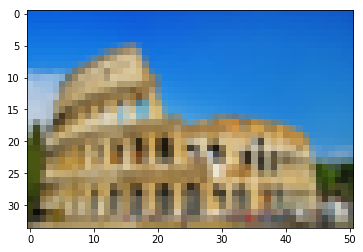

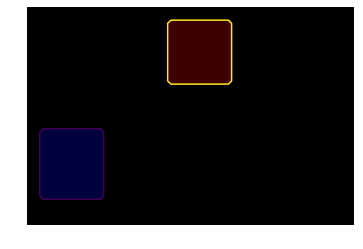

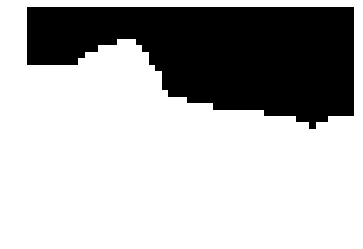